In [23]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, export_text
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold

In [ ]:

import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import seaborn as sns
from xgboost import XGBRegressor
import plotly.express as px
from statsmodels.tsa.arima_model import ARMA
import statistics
import matplotlib as plt
from math import *
#In [2]:
#Data downloaded from https://www.kaggle.com/c/rossmann-store-sales/data
#Reading the files
df = pd.read_csv("train.csv",parse_dates=[2], low_memory=False)
store = pd.read_csv("store.csv", low_memory=False)
#In [3]:
#Merging store and sales datasets
df_new = pd.merge(df, store, on='Store')
#In [4]:
#Preprocessing
#Converting Text Categories into Numerical Categories (Label Encoding)
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
df_new.StoreType.replace(mappings, inplace=True)
df_new.Assortment.replace(mappings, inplace=True)
df_new.StateHoliday.replace(mappings, inplace=True)
#Creating new features such as month, day, year, and weekday from date
df_new['Year'] = df_new.Date.dt.year
df_new['Month'] = df_new.Date.dt.month
df_new['Day'] = df_new.Date.dt.day
df_new['DayOfWeek'] = df_new.Date.dt.dayofweek
df_new['WeekOfYear'] = df_new.Date.dt.weekofyear
#Creating new features to determine time since competition open in terms of data
df_new['CompetitionOpen'] = 12 * (df_new.Year - df_new.CompetitionOpenSinceYear) +(df_new.Month - df_new.CompetitionOpenSinceMonth)
#Creating new features to determine time since clast promotion in terms of data
df_new['PromoOpen'] = 12 * (df_new.Year - df_new.Promo2SinceYear) + (df_new.WeekOfYear - df_new.Promo2SinceWeek) / 4.0
#replacing Msising values with 0
df_new['CompetitionOpen'] = df_new.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
df_new['PromoOpen'] = df_new.PromoOpen.apply(lambda x: x if x > 0 else 0)
df_new = df_new[df_new["Open"] != 0]
df_new = df_new[df_new["Sales"] > 0]
#replacing Msising values with median
df_new['CompetitionDistance'].fillna(df_new['CompetitionDistance'].median(), inplace = True)
df_new['CompetitionOpenSinceYear'].fillna(df_new['CompetitionDistance'].median(), inplace = True)
df_new['CompetitionOpenSinceMonth'].fillna(df_new['CompetitionDistance'].median(), inplace = True)
df_new['Promo2SinceWeek'].fillna(df_new['Promo2SinceWeek'].median(), inplace = True)
df_new['Promo2SinceYear'].fillna(df_new['Promo2SinceYear'].median(), inplace = True)
df_new['PromoInterval']=df_new['PromoInterval'].fillna("")
#Converting Monthly numeric levels to month strings
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df_new['monthStr'] = df_new.Month.map(month2str)
df_new.loc[df_new.PromoInterval == 0, 'PromoInterval'] = ''
#Splitting promo intervals into differnt months , splitting at ','
df_new['IsPromoMonth'] = 0
for interval in df_new.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            df_new.loc[(df_new.monthStr == month) & (df_new.PromoInterval == interval), 'IsPromoMonth'] = 1
df_new['average'] = df_new['Sales']/df_new['Customers']
df_new.drop(['Open','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)


In [5]:
#data preparation
#Defining the final Stacked Regressor Model
df1 = df_new[df_new['Store']==627]
#Train Test Split (last 6 weeks as test data)
test_a = df1[(df1['Date'] >= '2015-06-20')]
df_train = df1[(df1['Date'] < '2015-06-20')]
df_new1 = df_train.copy()
# df_new1 is the new train data
del df_new1['Sales']
del df_new1['Date']
del df_new1['Store']
del df_new1['StoreType']
del df_new1['Year']
del df_new1['SchoolHoliday']
del df_new1['Month']
#Data Prep - Removing features that are not required for modelling

del df_new1['StateHoliday']
del df_new1['Assortment']
del df_new1['CompetitionDistance']
del df_new1['CompetitionOpenSinceMonth']
del df_new1['CompetitionOpenSinceYear']
df_new1 = df_new1.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoOpen', 'IsPromoMonth'],axis = 1)

del df_new1['Promo']
del df_new1['WeekOfYear']
del df_new1['average']


df_test = test_a.copy()
del df_test['Sales']
del df_test['Date']
del df_test['Store']
del df_test['StoreType']
del df_test['StateHoliday']
del df_test['Assortment']
del df_test['CompetitionDistance']
del df_test['CompetitionOpenSinceMonth']
del df_test['CompetitionOpenSinceYear']
df_test = df_test.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoOpen', 'IsPromoMonth','SchoolHoliday','Year','Month'],axis = 1)
del df_test['average']

del df_test['Promo']
del df_test['WeekOfYear']
test = df_test.values
train2 = df_new1

## ARIMA MODEL BEFORE TUNING

In [8]:
from sklearn.metrics import mean_absolute_error
#Log transformation and adding constant 1 to deal with 0 values
y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
model=ARMA(df_train['Sales'],order=(0,1))
model_fit=model.fit(disp=False)
pred_arma = model_fit.predict(0,35)

print("ARIMA MODEL BEFORE TUNING - RMSE Score on test dataset is:",sqrt(mean_squared_error(pred_arma, test_a['Sales'])))
print("ARIMA MODEL BEFORE TUNING - MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_arma))

ARIMA MODEL BEFORE TUNING - RMSE Score on test dataset is: 1474.7317493345279
ARIMA MODEL BEFORE TUNING - MAE Score on test dataset is: 1116.9651485262218


C:\Users\prabh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


## ARIMA MODEL BEFORE TUNING

In [10]:
from sklearn.metrics import mean_absolute_error
#Log transformation and adding constant 1 to deal with 0 values
y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
model=ARMA(df_train['Sales'],order=(0,6))
model_fit=model.fit(disp=False)
pred_arma = model_fit.predict(0,35)

print("ARIMA MODEL AFTER TUNING - RMSE Score on test dataset is:",sqrt(mean_squared_error(pred_arma, test_a['Sales'])))
print("ARIMA MODEL AFTER TUNING - MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_arma))

C:\Users\prabh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA MODEL AFTER TUNING - RMSE Score on test dataset is: 1418.9602007159433
ARIMA MODEL AFTER TUNING - MAE Score on test dataset is: 1111.7700132187229


## DECISON TREE REGRESSOR BEFORE TUNING

In [105]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
    

    dt_regressor=DecisionTreeRegressor()
    dt_regressor.fit(train2.values, y_train1)
    predict_val=dt_regressor.predict(X_val)
    pred_a = np.exp(dt_regressor.predict(test))
    
    
    print("DECISION TREE MODEL - RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("DECISION TREE MODEL - MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


DECISION TREE MODEL - RMSE Score on test dataset is: 1130.1128999647192
DECISION TREE MODEL - MAE Score on test dataset is: 917.8333333333329


Assortments for this store by sales  


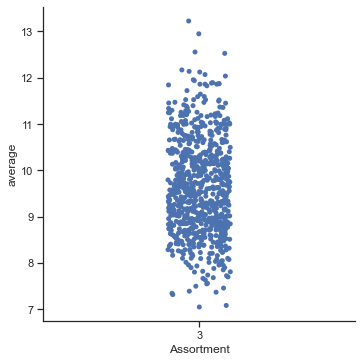

In [106]:
stacked(627)

## DECISION TREE REGRESSOR AFTER TUNING

In [107]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5]}
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
    
    cv = RepeatedKFold(n_splits=4, n_repeats=4, random_state=1)
    dt_regressor=DecisionTreeRegressor()
    tuning_model=GridSearchCV(dt_regressor,param_grid=parameters,scoring='neg_mean_squared_error',cv=cv,verbose=3)
    tuning_model.fit(train2.values, y_train1)
    predict_val=tuning_model.predict(X_val)
    pred_a = np.exp(tuning_model.predict(test))
    
    
    print("DECISION TREE MODEL - RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("DECISION TREE MODEL - MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


Fitting 16 folds for each of 6 candidates, totalling 96 fits
[CV 1/16] END ......max_depth=1, splitter=best;, score=-0.036 total time=   0.0s
[CV 2/16] END ......max_depth=1, splitter=best;, score=-0.035 total time=   0.0s
[CV 3/16] END ......max_depth=1, splitter=best;, score=-0.038 total time=   0.0s
[CV 4/16] END ......max_depth=1, splitter=best;, score=-0.045 total time=   0.0s
[CV 5/16] END ......max_depth=1, splitter=best;, score=-0.038 total time=   0.0s
[CV 6/16] END ......max_depth=1, splitter=best;, score=-0.039 total time=   0.0s
[CV 7/16] END ......max_depth=1, splitter=best;, score=-0.037 total time=   0.0s
[CV 8/16] END ......max_depth=1, splitter=best;, score=-0.039 total time=   0.0s
[CV 9/16] END ......max_depth=1, splitter=best;, score=-0.035 total time=   0.0s
[CV 10/16] END .....max_depth=1, splitter=best;, score=-0.043 total time=   0.0s
[CV 11/16] END .....max_depth=1, splitter=best;, score=-0.042 total time=   0.0s
[CV 12/16] END .....max_depth=1, splitter=best;,

Assortments for this store by sales  


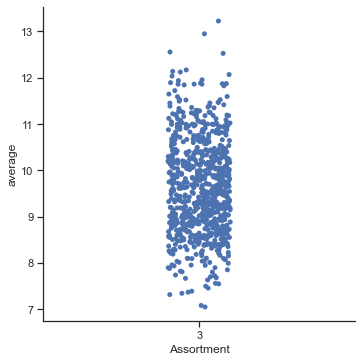

In [108]:
stacked (627)

## LASSSO REGRESSION BEFORE TUNING

In [109]:
def stacked1 (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
    
    lasso_model=Lasso()
    lasso_model.fit(train2.values, y_train1)
    predict_val=lasso_model.predict(X_val)
    pred_a = np.exp(lasso_model.predict(test))
   
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


RMSE Score on test dataset is: 1844.848079732298
MAE Score on test dataset is: 1477.313038692138


Assortments for this store by sales  


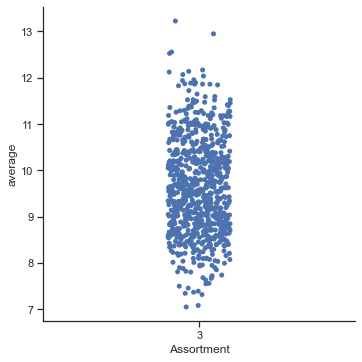

In [110]:
stacked1(627)

## LASSO REGRESSOR AFTER TUNING

In [111]:
def stacked3 (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    param = { 'alpha': [0.1,0.03,0.05,1]}
    
    #lasso_alphas = [0, 0.1, 0.2]
    lasso_model=Lasso()
    gscv = GridSearchCV(lasso_model, param_grid = param,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results = gscv.fit(train2.values, y_train1)

    

    predict_val=results.predict(X_val)
    pred_a = np.exp(results.predict(test))
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


RMSE Score on test dataset is: 847.508292588666
MAE Score on test dataset is: 706.8913451364874


Assortments for this store by sales  


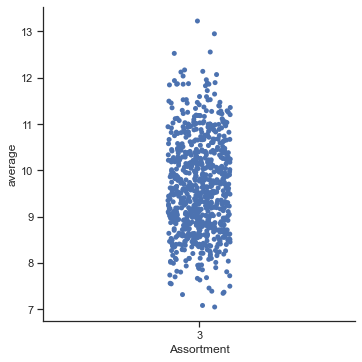

In [112]:
stacked3(627)

## RIDGE REGRESSOR BEFORE TUNING

In [113]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
#Instantiating models for stacked regressors


    ridge_model=Ridge()
    ridge_model.fit(train2.values, y_train1)
    y_pred=ridge_model.predict(X_val)
    pred_a = np.exp(ridge_model.predict(test))
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


RMSE Score on test dataset is: 988.7991909972407
MAE Score on test dataset is: 825.4659311330565


Assortments for this store by sales  


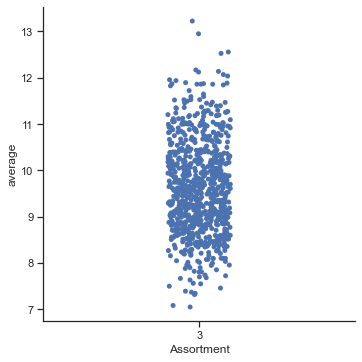

In [114]:
stacked(627)

## RIDGE REGRESSOR AFTER TUNING

In [69]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
#Instantiating models for stacked regressors
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    param = { 'alpha': [1,2]}
    
    #lasso_alphas = [0, 0.1, 0.2]
    ridge_model=Ridge()
    gscv = GridSearchCV(ridge_model, param_grid = param,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results = gscv.fit(train2.values, y_train1)

    
    y_pred=results.predict(X_val)
    pred_a = np.exp(results.predict(test))
    
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    
    
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


RMSE Score on test dataset is: 988.7991909972407
MAE Score on test dataset is: 825.4659311330565


Assortments for this store by sales  


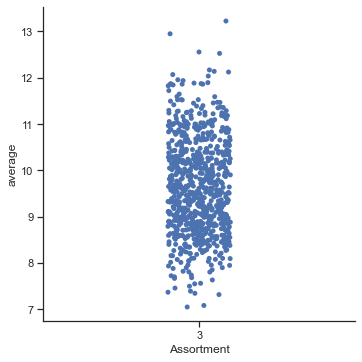

In [70]:
stacked(627)

## STACKED REGRESSION MODEL BEFORE TUNING

In [115]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
#Instantiating models for stacked regressors
  
    from sklearn.ensemble import RandomForestRegressor
    random_forest = RandomForestRegressor()
    from sklearn.linear_model import ElasticNetCV
    model_elastic = ElasticNetCV()
    from sklearn.linear_model import LassoCV
    model_lasso = LassoCV()
    from sklearn.linear_model import RidgeCV
    model_ridge = RidgeCV()
    from sklearn.ensemble import ExtraTreesRegressor
#MEta regressor
    tree_model = ExtraTreesRegressor()
    from sklearn.linear_model import BayesianRidge
    clf = BayesianRidge()
    from lightgbm import LGBMRegressor
    light = LGBMRegressor(random_state=1231)
    xgboost_tree = xgb.XGBRegressor(eta = 0.19)
    from mlxtend.regressor import StackingRegressor
    #Stacking all models in stackingregressors
    stregr = StackingRegressor(regressors=[model_lasso,clf,xgboost_tree,model_elastic, model_ridge,random_forest ], 
                           meta_regressor=tree_model)
    # Model fit
    stregr.fit(train2.values, y_train1)
    from sklearn.metrics import r2_score
# r2 check
    predict_val = stregr.predict(X_val)
    pred_a = np.exp(stregr.predict(test))
    
    from sklearn.metrics import accuracy_score
    print("STACKED REGRESSION MODEL - RMSE Score on test dataset is:",np.round(np.sqrt(mean_squared_error(test_a['Sales'],pred_a))),2)
    print("STACKED REGRESSION MODEL - MAE Score on test dataset is:",np.round(mean_absolute_error(test_a['Sales'],pred_a)),2)

    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()

In [116]:
stacked(627)

STACKED REGRESSION MODEL - RMSE Score on test dataset is: 840.0 2
STACKED REGRESSION MODEL - MAE Score on test dataset is: 676.0 2


## STACKED REGRESSOR MODEL AFTER TUNING

In [92]:
def stacked (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
#Instantiating models for stacked regressors
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

    param = { 
            'n_estimator': [50,100,1000,1500],
            'max_depth': [2,4,6,8]
         }

    

    
    from sklearn.ensemble import RandomForestRegressor
    random_forest = RandomForestRegressor(n_estimators=20, oob_score=True, bootstrap=True, max_depth=4, random_state=442)
    from sklearn.linear_model import ElasticNetCV
    model_elastic = ElasticNetCV(l1_ratio=[.1, .4, .5, .6, .7, .8, .9, .95, .99, 1], cv=cv, random_state=42)
    from sklearn.linear_model import LassoCV
    model_lasso = LassoCV(alphas = [1, 0.01, 0.0001, 0.0001, 0.0005], cv=cv, random_state=4142)
    from sklearn.linear_model import RidgeCV
    model_ridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0001, 0.0005,0], cv=cv)
    from sklearn.ensemble import ExtraTreesRegressor
#MEta regressor
    tree_model = ExtraTreesRegressor(n_estimators=53, oob_score=True, bootstrap=True, max_depth=4, random_state=2241)
    from sklearn.linear_model import BayesianRidge
    clf = BayesianRidge()
    from lightgbm import LGBMRegressor
    light = LGBMRegressor(random_state=1231)
    xgboost_tree = xgb.XGBRegressor(eta = 0.19,
                                    min_child_weight = 2,subsample = 0.8,colsample_bytree = 0.8,
                                    tree_method = 'exact',reg_alpha = 0.05,silent = 0,randm_state = 1023)
    from mlxtend.regressor import StackingRegressor
    #Stacking all models in stackingregressors
    stregr = StackingRegressor(regressors=[model_lasso,clf,xgboost_tree,model_elastic, model_ridge,random_forest ], 
                           meta_regressor=tree_model)
    # Model fit
    stregr.fit(train2.values, y_train1)
    from sklearn.metrics import r2_score
# r2 check
    predict_val = stregr.predict(X_val)
    pred_a = np.exp(stregr.predict(test))
    
    from sklearn.metrics import accuracy_score
    print("STACKED REGRESSION MODEL - RMSE Score on test dataset is:",np.round(np.sqrt(mean_squared_error(test_a['Sales'],pred_a))),2)
    print("STACKED REGRESSION MODEL - MAE Score on test dataset is:",np.round(mean_absolute_error(test_a['Sales'],pred_a)),2)

    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


[20:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { randm_state, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


STACKED REGRESSION MODEL - RMSE Score on test dataset is: 656.0 2
STACKED REGRESSION MODEL - MAE Score on test dataset is: 536.0 2


Assortments for this store by sales  


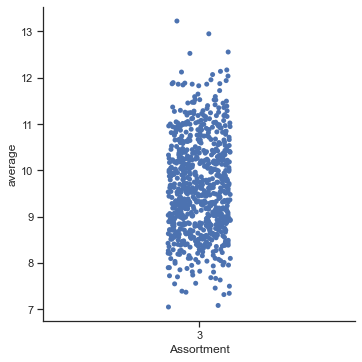

In [93]:
stacked(627)

## EXTREME GRADIENT BOOSTING MODEL BEFORE TUNING

In [103]:
def stacked1 (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns


    xgboost_tree = xgb.XGBRegressor(eta = 0.19,
                                    min_child_weight = 2,subsample = 0.8,colsample_bytree = 0.8,
                                    tree_method = 'exact',reg_alpha = 0.05,silent = 0,randm_state = 1023)

    #grid = GridSearchCV(estimator = xgboost_tree,param_grid=param,cv=5,verbose=1,n_jobs=-1,scoring='neg_mean_squared_error')

    grid_result = xgboost_tree.fit(train2.values,y_train1)
    #best_params = xgboost_tree.best_params_

    pred = xgboost_tree.predict(X_val)
    pred_a = np.exp(xgboost_tree.predict(test))
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
   
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


[20:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { randm_state, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE Score on test dataset is: 694.1487619022073
MAE Score on test dataset is: 568.2561442057291


Assortments for this store by sales  


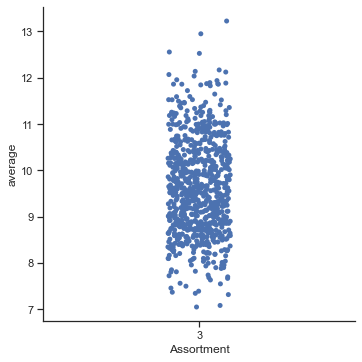

In [104]:
stacked1(627)

## EXTREME GRADIENT BOOSTING MODEL AFTER TUNING

In [95]:
def stacked1 (store_num):
    df1 = df_new[df_new['Store']==store_num]
#Train Test Split (last 6 weeks as test data)
    test_a = df1[(df1['Date'] >= '2015-06-20')]
    df_train = df1[(df1['Date'] < '2015-06-20')]
    df_new1 = df_train.copy()
#Data Prep - Removing features that are not required for modelling
    del df_new1['Sales']
    del df_new1['Date']
    del df_new1['Store']
    del df_new1['StoreType']
    df_test = test_a.copy()
    del df_test['Sales']
    del df_test['Date']
    del df_test['Store']
    del df_test['StoreType']
    test = df_test.values
    train2 = df_new1
#Log transformation and adding constant 1 to deal with 0 values
    y_train1 = np.log(df_train['Sales'] + 1)
#ARMA model with order of (0,1) to forecast only using moving averages
    model=ARMA(df_train['Sales'],order=(0,1))
    model_fit=model.fit(disp=False)
    pred_arma = model_fit.predict(0,41)
#Creating train and test dataset 
    X_train, X_val, y_train, y_val = train_test_split(train2.values, y_train1, test_size=0.15, random_state=4242)
    df_columns = train2.columns
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    param = { 
            'n_estimator': [50,100,1000,1500],
            'max_depth': [2,4,6,8,10]
         }

    xgboost_tree = xgb.XGBRegressor(eta = 0.19,
                                    min_child_weight = 2,subsample = 0.8,colsample_bytree = 0.8,
                                    tree_method = 'exact',reg_alpha = 0.05,silent = 0,randm_state = 1023)

    grid = GridSearchCV(estimator = xgboost_tree,param_grid=param,cv=cv,verbose=1,n_jobs=-1,scoring='neg_mean_squared_error')

    grid_result = grid.fit(train2.values,y_train1)
    best_params = grid_result.best_params_

    pred = grid_result.predict(X_val)
    pred_a = np.exp(grid_result.predict(test))
    
    print("RMSE Score on test dataset is:",np.sqrt(mean_squared_error(test_a['Sales'],pred_a)))
    print("MAE Score on test dataset is:",mean_absolute_error(test_a['Sales'],pred_a))
    fig = px.line(title="Actual Sales vs Moving Averages Forecasts (6 weeks)")
    fig.add_scatter(x=test_a['Date'], y=test_a['Sales'], name="Actual Sales")
    fig.add_scatter(x=test_a['Date'], y=pred_arma, name="Moving Averages Forecast") 
    fig.add_scatter(x=test_a['Date'], y=pred_a, name="Predictive Model Forecasts") 
    
    fig.update_layout(showlegend=True)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 10, 0, 0)',
    })
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror = True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',  mirror = True)
    fig.update_layout(xaxis_title="Date",yaxis_title="Sales")
    fig.show()
    fig1 = px.bar(df_train,
             y='Sales',
             x="DayOfWeek",
             color='Promo', title="Sales by day of Week")
    fig1.show()
    fig2 = px.bar(df_train,
             y='Sales',
             x="Month",
             color='Promo', title="Sales Month")
    fig2.show()
    print("Assortments for this store by sales  ")
    sns.set(style="ticks", color_codes=True)
    tips = sns.load_dataset("tips")
    sns.catplot(x="Assortment", y="average", data=df1);


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[20:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator, randm_state, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE Score on test dataset is: 634.3359283029387
MAE Score on test dataset is: 506.51116265190973


Assortments for this store by sales  


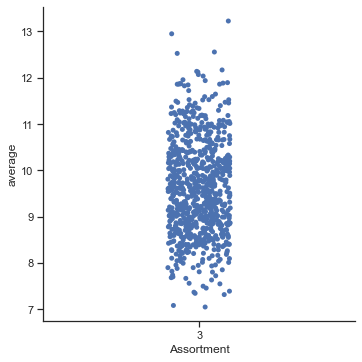

In [96]:
stacked1(627)